## Final Code

In [ ]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier, FinetuneableZoobotRegressor
from zoobot.pytorch.training.finetune import FinetuneableZoobotAbstract
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule

from zoobot.pytorch.training.finetune import LinearHead
import logging
from functools import partial
import torchmetrics as tm
from zoobot.pytorch.training.finetune import cross_entropy_loss, mse_loss, l1_loss
from typing import Union
import torch.nn.functional as F


import torch
import pandas as pd

import os

In [ ]:
# Define metadata and label columns
metadata_columns = ['nsa_sersic_flux_F', 'nsa_sersic_flux_N', 'nsa_sersic_flux_u', 'nsa_sersic_flux_g', 'nsa_sersic_flux_r', 'nsa_sersic_flux_i', 'nsa_sersic_flux_z']
label_columns = ['Vm']

In [ ]:
class FinetuneableZoobotMetadataAbstract(FinetuneableZoobotAbstract):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def run_step_through_model(self, batch):
        # part of training/val/test for all subclasses
        image, y = self.batch_to_supervised_tuple(batch)
        y_pred = self.forward(batch)
             
        # must be subclasses and specified
        loss = self.loss(y_pred, y)  # type:ignore
        loss.float()
        return y, y_pred, loss

In [ ]:
class FinetuneableZoobotMetadataClassifier(FinetuneableZoobotMetadataAbstract, FinetuneableZoobotClassifier):    
    def __init__(
            self,
            num_classes: int,
            label_col: str = 'label',
            label_smoothing=0.,
            class_weights=None,
            metadata_cols=None,

            run_linear_sanity_check: bool = False,
            **super_kwargs) -> None:

        super().__init__(
            num_classes=num_classes,
            label_col=label_col,
            label_smoothing=label_smoothing,
            class_weights=class_weights,
            **super_kwargs
        )

        self.label_col = label_col
        
        logging.info("Using classification head and cross-entropy loss")
        self.head = LinearHead(
            input_dim=self.encoder_dim,  # type: ignore
            output_dim=num_classes,
            head_dropout_prob=self.head_dropout_prob,
        )
        self.label_smoothing = label_smoothing

        # if isinstance(class_weights, list) or isinstance(class_weights, np.ndarray):
        if class_weights is not None:
            # https://lightning.ai/docs/pytorch/stable/accelerators/accelerator_prepare.html#init-tensors-using-tensor-to-and-register-buffer
            self.register_buffer("class_weights", torch.Tensor(class_weights))
            print(self.class_weights, self.class_weights.device)  # type: ignore
            # can now use self.class_weights in forward pass and will be on correct device (because treated as model parameters)
        else:
            self.class_weights = None

        self.loss = partial(cross_entropy_loss,
                            weight=self.class_weights,
                            label_smoothing=self.label_smoothing)
        logging.info(f'num_classes: {num_classes}')

        if num_classes == 2:
            logging.info("Using binary classification")
            task = "binary"
        else:
            logging.info("Using multi-class classification")
            task = "multiclass"
        self.train_acc = tm.Accuracy(task=task, average="micro", num_classes=num_classes)
        self.val_acc = tm.Accuracy(task=task, average="micro", num_classes=num_classes)
        self.test_acc = tm.Accuracy(task=task, average="micro", num_classes=num_classes)

        self.run_linear_sanity_check = run_linear_sanity_check
        
        self.metadata_cols = metadata_cols or []
        metadata_dim = len(self.metadata_cols)
        
        prev_head = self.head
        self.head = LinearHead(
            input_dim=prev_head.input_dim + metadata_dim,
            output_dim=num_classes,
            head_dropout_prob=prev_head.dropout.p,
        )
        
    def predict_step(self, x: Union[list[torch.Tensor], torch.Tensor], batch_idx):
        # overrides abstract version
        x = self.forward(x)  # type: ignore # logits from LinearHead
        # then applies softmax. Only in predict step because we prefer logits for gradient stability during training
        return F.softmax(x, dim=1)
        
    def forward(self, batch):
        x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
        x = self.encoder(x)

        # collect metadata columns as tensor
        if self.metadata_cols:
            metadata = torch.cat([
                torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)
                for col in self.metadata_cols
            ], dim=1)
            x = torch.cat([x, metadata], dim=1)

        x = self.head(x)
        return x


In [ ]:
class FinetuneableZoobotMetadataRegressor(FinetuneableZoobotMetadataAbstract, FinetuneableZoobotRegressor): 
    def __init__(
            self,
            label_col: str = 'label',
            loss: str = 'mse',
            unit_interval: bool = False,
            metadata_cols=None,

            **super_kwargs) -> None:

        super().__init__(**super_kwargs)

        self.label_col = label_col  # TODO could add MultipleLabelRegressor, Nasser working on this

        self.unit_interval = unit_interval
        if self.unit_interval:
            logging.info("unit_interval=True, using sigmoid activation for finetunng head")
            head_activation = torch.nn.functional.sigmoid
        else:
            head_activation = None

        logging.info("Using classification head and cross-entropy loss")
        self.head = LinearHead(
            input_dim=self.encoder_dim,
            output_dim=1,
            head_dropout_prob=self.head_dropout_prob,
            activation=head_activation,
        )
        if loss in ["mse", "mean_squared_error"]:
            self.loss = mse_loss
        elif loss in ["mae", "mean_absolute_error", "l1", "l1_loss"]:
            self.loss = l1_loss
        else:
            raise ValueError(f"Loss {loss} not recognised. Must be one of mse, mae")

        # rmse metrics. loss is mse already.
        self.train_rmse = tm.MeanSquaredError(squared=False)
        self.val_rmse = tm.MeanSquaredError(squared=False)
        self.test_rmse = tm.MeanSquaredError(squared=False)
        
        self.metadata_cols = metadata_cols or []
        metadata_dim = len(self.metadata_cols)
        
        prev_head = self.head
        self.head = LinearHead(
            input_dim=prev_head.input_dim + metadata_dim,
            output_dim=prev_head.output_dim,
            head_dropout_prob=prev_head.dropout.p,
        )
    
    def predict_step(self, x: torch.Tensor, batch_idx):
        return self.forward(x)
        
    def forward(self, batch):
        x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
        x = self.encoder(x)

        # collect metadata columns as tensor
        if self.metadata_cols:
            metadata = torch.cat([
                torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)
                for col in self.metadata_cols
            ], dim=1)
            x = torch.cat([x, metadata], dim=1)

        x = self.head(x)
        return x


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def normalize(array):
    """
    Normalize values between 0 and 1 using min-max scaling.
    
    Args:
        array (pd.Series): Values to normalize.
    
    Returns:
        tuple: (pd.Series with normalized values as float32, fitted MinMaxScaler)
    """
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(array.to_numpy().reshape(-1, 1))
    norm_series = pd.Series(
        normalized.flatten(),
        index=array.index,
        name='norm',
        dtype='float32'
    )
    return norm_series, scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def unnormalize(norm_array, scaler):
    """
    Revert min-max normalization using the fitted scaler
    
    Args:
        norm_array: pandas Series or numpy array of normalized values
        scaler: fitted MinMaxScaler used in the normalize() function
    
    Returns:
        pandas Series of original scale values as float32
    """
    unnorm = scaler.inverse_transform(norm_array.values.reshape(-1, 1))
    return pd.Series(unnorm.flatten(), index=norm_array.index, name='original', dtype='float32')

In [ ]:
model = FinetuneableZoobotMetadataRegressor(
    name='nassm/convnext_nano',
    label_col=label_columns[0],
    metadata_cols=metadata_columns
)

In [ ]:
train_metadata = pd.read_csv('/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/rot/train_dataset.csv')
test_metadata = pd.read_csv('/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/rot/test_dataset.csv')

In [ ]:
train_metadata.head()

,plateifu,Rt,Vm,I,subfolder,filename,file_loc,z,DA,Re_arcsec_MGE,...,feat_pca_10,feat_pca_11,feat_pca_12,feat_pca_13,feat_pca_14,feat_pca_15,feat_pca_16,feat_pca_17,feat_pca_18,feat_pca_19
0,12506-6103,4.061448,86.243033,0.885726,12506,6103.jpeg,/rot/images/12506/6103.jpeg,0.023074,99.280,7.238409,...,-1.165081,1.874536,1.712885,-1.063189,-1.675569,-0.349349,0.191458,1.291329,-0.572528,1.558425
1,9186-6103,2.651143,402.344941,0.487016,9186,6103.jpeg,/rot/images/9186/6103.jpeg,0.054692,226.556,10.199610,...,-4.759610,-5.716032,2.361270,1.653523,-1.010131,-1.832795,0.791641,4.169818,2.103140,0.879104
2,8547-6104,2.259231,134.791183,0.904476,8547,6104.jpeg,/rot/images/8547/6104.jpeg,0.038116,161.047,3.109727,...,-0.141378,-0.574500,1.275496,-0.690784,-0.958151,0.464616,0.286854,0.128899,-1.462401,-0.413540
3,12652-12704,4.839616,142.681723,0.988615,12652,12704.jpeg,/rot/images/12652/12704.jpeg,0.045799,191.739,7.808920,...,-4.794197,2.468026,4.203431,0.825131,-0.629933,3.028497,-0.392327,2.334577,0.243934,0.814129
4,9035-12704,5.189646,-123.274027,0.964026,9035,12704.jpeg,/rot/images/9035/12704.jpeg,0.037896,160.160,4.309199,...,0.847692,-2.488838,0.652108,0.764562,-0.654820,2.072596,-2.014786,-1.367212,0.334174,1.647105


In [ ]:
import numpy as np
train_metadata["file_loc"] = "/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata" + train_metadata["file_loc"].astype(str)
test_metadata["file_loc"] = "/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata" + test_metadata["file_loc"].astype(str)

train_metadata["id_str"] = train_metadata["plateifu"]
test_metadata['id_str'] = train_metadata["plateifu"]

train_metadata['Vm'], normalize_scaler_train = normalize(np.abs(train_metadata['Vm']))
test_metadata['Vm'], normalize_scaler_test = normalize(np.abs(test_metadata['Vm']))

In [ ]:
normalize_scaler_train.scale_

array([0.00240971])

In [ ]:
train_metadata.head()

,plateifu,Rt,Vm,I,subfolder,filename,file_loc,z,DA,Re_arcsec_MGE,...,feat_pca_11,feat_pca_12,feat_pca_13,feat_pca_14,feat_pca_15,feat_pca_16,feat_pca_17,feat_pca_18,feat_pca_19,id_str
0,12506-6103,4.061448,0.087178,0.885726,12506,6103.jpeg,/home/nasserm/local/zoobot/examples/finetuning...,0.023074,99.280,7.238409,...,1.874536,1.712885,-1.063189,-1.675569,-0.349349,0.191458,1.291329,-0.572528,1.558425,12506-6103
1,9186-6103,2.651143,0.848892,0.487016,9186,6103.jpeg,/home/nasserm/local/zoobot/examples/finetuning...,0.054692,226.556,10.199610,...,-5.716032,2.361270,1.653523,-1.010131,-1.832795,0.791641,4.169818,2.103140,0.879104,9186-6103
2,8547-6104,2.259231,0.204165,0.904476,8547,6104.jpeg,/home/nasserm/local/zoobot/examples/finetuning...,0.038116,161.047,3.109727,...,-0.574500,1.275496,-0.690784,-0.958151,0.464616,0.286854,0.128899,-1.462401,-0.413540,8547-6104
3,12652-12704,4.839616,0.223179,0.988615,12652,12704.jpeg,/home/nasserm/local/zoobot/examples/finetuning...,0.045799,191.739,7.808920,...,2.468026,4.203431,0.825131,-0.629933,3.028497,-0.392327,2.334577,0.243934,0.814129,12652-12704
4,9035-12704,5.189646,0.176412,0.964026,9035,12704.jpeg,/home/nasserm/local/zoobot/examples/finetuning...,0.037896,160.160,4.309199,...,-2.488838,0.652108,0.764562,-0.654820,2.072596,-2.014786,-1.367212,0.334174,1.647105,9035-12704


In [ ]:
datamodule = CatalogDataModule(
  label_cols=label_columns + metadata_columns,
  catalog=train_metadata,
  train_transform=transform,
  test_transform=transform,
  batch_size=8,
)

In [ ]:
model.head

LinearHead(
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=647, out_features=1, bias=True)
)

### Training

In [59]:
from zoobot.pytorch.training.finetune import get_trainer

datamodule.setup("fit")

save_dir = os.path.join('./save_dir2/')

trainer = get_trainer(save_dir, accelerator="auto", devices=1, strategy="auto", max_epochs=200)
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/nasserm/local/miniconda3/envs/mangazoo/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | encoder           | ConvNeXt         | 15.0 M | train
1 | train_loss_metric | MeanMetric       | 0      | train
2 | val_loss_metric   | MeanMetric       | 0      | train
3 | test_loss_metric  | MeanMetric       | 0      | train
4 | head              | LinearHead       | 648    | train
5 | train_rmse        | MeanSquaredError | 0      | train
6 | val_rmse          | MeanSquaredError | 0      | train
7 | test_rmse         | MeanSquaredError | 0      | train
---------------------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_147837/154344344.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
/tmp/ipykernel_147837/154344344.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 202: 'finetuning/val_loss' reached 1642.80896 (best 1642.80896), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 404: 'finetuning/val_loss' reached 1448.49426 (best 1448.49426), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 606: 'finetuning/val_loss' reached 1176.20605 (best 1176.20605), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 808: 'finetuning/val_loss' reached 977.34497 (best 977.34497), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1010: 'finetuning/val_loss' reached 765.06818 (best 765.06818), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1212: 'finetuning/val_loss' reached 656.19659 (best 656.19659), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/5-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1414: 'finetuning/val_loss' reached 576.74530 (best 576.74530), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1616: 'finetuning/val_loss' reached 523.01764 (best 523.01764), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1818: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2020: 'finetuning/val_loss' reached 395.82199 (best 395.82199), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 2222: 'finetuning/val_loss' reached 317.46140 (best 317.46140), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 2424: 'finetuning/val_loss' reached 263.97504 (best 263.97504), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 2626: 'finetuning/val_loss' reached 212.14436 (best 212.14436), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2828: 'finetuning/val_loss' reached 179.63876 (best 179.63876), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 3030: 'finetuning/val_loss' reached 152.83942 (best 152.83942), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 3232: 'finetuning/val_loss' reached 136.17751 (best 136.17751), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 3434: 'finetuning/val_loss' reached 107.29115 (best 107.29115), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/16.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 3636: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 3838: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 4040: 'finetuning/val_loss' reached 93.84467 (best 93.84467), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/19-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 4242: 'finetuning/val_loss' reached 79.16866 (best 79.16866), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 4444: 'finetuning/val_loss' reached 73.65254 (best 73.65254), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 4646: 'finetuning/val_loss' reached 65.03188 (best 65.03188), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 4848: 'finetuning/val_loss' reached 57.76526 (best 57.76526), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/23.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 5050: 'finetuning/val_loss' reached 50.03507 (best 50.03507), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 5252: 'finetuning/val_loss' reached 44.95480 (best 44.95480), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/25.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 5454: 'finetuning/val_loss' reached 35.79265 (best 35.79265), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/26.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 5656: 'finetuning/val_loss' reached 30.68394 (best 30.68394), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 5858: 'finetuning/val_loss' reached 22.67042 (best 22.67042), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 6060: 'finetuning/val_loss' reached 18.43469 (best 18.43469), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/29.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 6262: 'finetuning/val_loss' reached 13.40362 (best 13.40362), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/30.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 6464: 'finetuning/val_loss' reached 9.52217 (best 9.52217), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/31.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 6666: 'finetuning/val_loss' reached 6.50227 (best 6.50227), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/32.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 6868: 'finetuning/val_loss' reached 3.72789 (best 3.72789), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 7070: 'finetuning/val_loss' reached 2.35129 (best 2.35129), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 7272: 'finetuning/val_loss' reached 1.05109 (best 1.05109), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/35.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 7474: 'finetuning/val_loss' reached 0.84054 (best 0.84054), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/36.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 7676: 'finetuning/val_loss' reached 0.10482 (best 0.10482), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/37.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 7878: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 8080: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 8282: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 8484: 'finetuning/val_loss' reached 0.05767 (best 0.05767), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/41.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 8686: 'finetuning/val_loss' reached 0.05480 (best 0.05480), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 8888: 'finetuning/val_loss' reached 0.05299 (best 0.05299), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/43.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 9090: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 9292: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 9494: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 9696: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 9898: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 10100: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 10302: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 10504: 'finetuning/val_loss' reached 0.05248 (best 0.05248), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 10706: 'finetuning/val_loss' reached 0.04482 (best 0.04482), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 10908: 'finetuning/val_loss' reached 0.03663 (best 0.03663), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 11110: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 11312: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 11514: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 11716: 'finetuning/val_loss' reached 0.02450 (best 0.02450), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 11918: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 12120: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 12322: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 12524: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 12726: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 12928: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 13130: 'finetuning/val_loss' reached 0.02203 (best 0.02203), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 13332: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 13534: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 13736: 'finetuning/val_loss' reached 0.01668 (best 0.01668), saving model to '/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 13938: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 14140: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 14342: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 14544: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 14746: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 14948: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 15150: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 15352: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 15554: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 15756: 'finetuning/val_loss' was not in top 1


### Prediction

In [62]:
finetuned_model = FinetuneableZoobotMetadataRegressor.load_from_checkpoint('/geir_data/scr/nasserm/zoobot/zoobot_metadata/save_dir2/checkpoints/67.ckpt')

# best_checkpoint = trainer.checkpoint_callback.best_model_path
# finetuned_model = FinetuneableZoobotMetadataRegressor.load_from_checkpoint(best_checkpoint)


In [63]:
from PIL import Image
import numpy as np
data=test_metadata.iloc[0].to_dict()
img_path = data['file_loc']
img = Image.open(img_path).convert('RGB')
img_t = transform(img) 
if isinstance(img_t, torch.Tensor):
    data['image'] = img_t.unsqueeze(0)  # (1,3,H,W)
else:
    # transform returned numpy array
    data['image'] = np.expand_dims(img_t, 0)  # (1,3,H,W)

for col in model.metadata_cols:
    # wrap scalar into length-1 array
    data[col] = np.expand_dims(np.array(data[col], dtype=float), 0)

finetuned_model(data)

/tmp/ipykernel_147837/154344344.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)


tensor(0.3451, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [64]:
predict_datamodule = CatalogDataModule(
        label_cols=metadata_columns,
        predict_catalog=test_metadata,  # no need to specify the other catalogs
        test_transform=transform,  # see galaxy-datasets, e.g. torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), torchvision.transforms.ToTensor()])
    )


import lightning as L
trainer = L.Trainer(
        max_epochs=-1,  # does nothing in this context, suppresses warning
    )

predictions = torch.cat(trainer.predict(finetuned_model, predict_datamodule), dim=0)  # in latest version, now a tensor
prediction_df = pd.DataFrame(predictions.numpy())

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_147837/154344344.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
/tmp/ipykernel_147837/154344344.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)


In [65]:
prediction_df.mean()

0    0.321394
dtype: float32

[plot debug] using scaler from: normalize_scaler_train
[plot debug] x (first 5, normalized): [0.39558092 0.26580846 0.18221341 0.52122176 0.0807855 ]
[plot debug] y (first 5, normalized): [0.26380098 0.24720404 0.1766358  0.52537924 0.15485474]
[plot debug] x (first 5, unnormalized): [214.22643 160.3724  125.68144 266.36588  83.59007]
[plot debug] y (first 5, unnormalized): [159.53932  152.65178  123.366806 268.09116  114.327934]


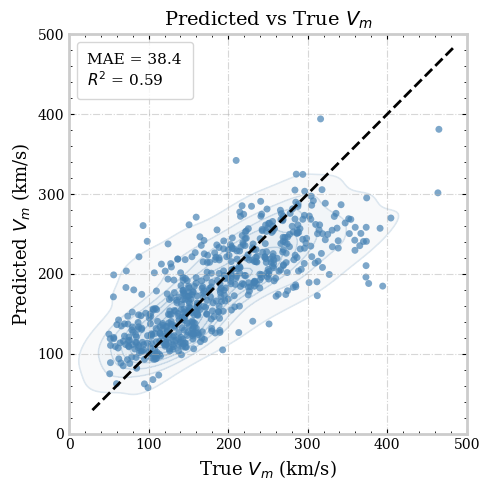

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.lines import Line2D

def plot_form(ax):
    ax.grid(ls='-.', alpha=0.5, zorder=0)
    ax.tick_params(direction='in')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color('0.8')
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.minorticks_on()
    plt.rcParams['font.family'] = 'serif'

# Merge predictions with true values using id_str
merged = test_metadata.copy()
# prediction_df can be a DataFrame, tensor or array; coerce to 1D array/Series
if isinstance(prediction_df, pd.DataFrame):
    # take first column if multiple
    pred_series = pd.Series(prediction_df.iloc[:, 0].values, index=merged.index)
else:
    try:
        pred_series = pd.Series(np.array(prediction_df).flatten(), index=merged.index)
    except Exception:
        # fallback: keep as-is
        pred_series = pd.Series(prediction_df)
merged['Vm_pred'] = pred_series

# helper: metrics legend
def add_metrics_legend(ax, y_true, y_pred):
    def sigfig(x, n=2):
        if x == 0:
            return "0"
        return f"{x:.{n}g}"
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    text = f"MAE = {sigfig(mae, 3)}\n$R^2$ = {sigfig(r2, 2)}"
    handle = Line2D([], [], marker='o', color='w', alpha=0, linestyle='None')
    ax.legend([handle], [text], loc='upper left', fontsize=11, frameon=True,
              borderpad=0.7, labelspacing=0.3, handlelength=0, handletextpad=0)

# helper: contours
def plot_contours(ax, x, y):
    cmap = sns.light_palette('steelblue', as_cmap=True)
    if len(x) > 10:
        try:
            sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap=cmap,
                        levels=8, thresh=0.05, alpha=0.25, zorder=0)
            sns.kdeplot(x=x, y=y, ax=ax, color='steelblue',
                        levels=8, thresh=0.05, linewidths=1.2,
                        fill=False, alpha=0.15, zorder=1)
        except Exception:
            pass

# --- Un-normalize before plotting using stored scalers (preferred) ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# defaults are the normalized columns
x = merged['Vm']
y = merged['Vm_pred']
units = ''
# Try to unnormalize using scalers created earlier in the notebook; if missing, try to rebuild from known CSV paths
try:
    scaler = None
    used = None
    if 'normalize_scaler_train' in globals() and normalize_scaler_train is not None:
        scaler = normalize_scaler_train
        used = 'normalize_scaler_train'
    elif 'normalize_scaler_test' in globals() and normalize_scaler_test is not None:
        scaler = normalize_scaler_test
        used = 'normalize_scaler_test'

    # if no in-memory scaler, try to rebuild from the original training CSV used earlier
    if scaler is None:
        possible_paths = [
            '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/rot/train_dataset.csv',
            'rot/train_dataset.csv',
            './rot/train_dataset.csv',
        ]
        for p in possible_paths:
            try:
                if os.path.exists(p):
                    raw_train = pd.read_csv(p)
                    if 'Vm' in raw_train.columns:
                        scaler = MinMaxScaler()
                        scaler.fit(np.abs(raw_train['Vm']).values.reshape(-1, 1))
                        used = p
                        break
            except Exception:
                continue

    if scaler is None:
        raise NameError('No stored scaler found and rebuild failed')

    # ensure x,y are pandas Series with the same index as merged
    x_series = pd.Series(x.values if hasattr(x, 'values') else np.array(x).flatten(), index=merged.index)
    y_series = pd.Series(y.values if hasattr(y, 'values') else np.array(y).flatten(), index=merged.index)

    # diagnostics: show scaler source and sample values before unnormalization
    try:
        print(f"[plot debug] using scaler from: {used}")
    except Exception:
        print("[plot debug] scaler source unknown")
    print("[plot debug] x (first 5, normalized):", x_series.head().values)
    print("[plot debug] y (first 5, normalized):", y_series.head().values)

    x_unnorm = unnormalize(x_series, scaler)
    y_unnorm = unnormalize(y_series, scaler)

    print("[plot debug] x (first 5, unnormalized):", x_unnorm.head().values)
    print("[plot debug] y (first 5, unnormalized):", y_unnorm.head().values)

    x = x_unnorm.values
    y = y_unnorm.values
    units = ' (km/s)'
except Exception:
    # fallback: keep x,y as normalized values (they may already be Series/arrays)
    if hasattr(x, 'values'):
        x = x.values
    else:
        x = np.array(x).flatten()
    if hasattr(y, 'values'):
        y = y.values
    else:
        y = np.array(y).flatten()
    units = ''

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_form(ax)

plot_contours(ax, x, y)
sns.scatterplot(x=x, y=y, ax=ax, alpha=0.7, s=25, color='steelblue', edgecolor='none')

try:
    mn = min(np.nanmin(x), np.nanmin(y))
    mx = max(np.nanmax(x), np.nanmax(y))
    pad = 0.05 * (mx - mn) if mx > mn else 0.1
    ax.plot([mn - pad, mx + pad], [mn - pad, mx + pad], color='black', linestyle='--', linewidth=2)
    ax.set_xlim(mn - pad, mx + pad)
    ax.set_ylim(mn - pad, mx + pad)
except Exception:
    # fallback to normalized axis limits
    ax.plot([x.min()-0.1, x.max()], [x.min()-0.1, x.max()], color='black', linestyle='--', linewidth=2)
    ax.set_xlim(-0.1, 1)
    ax.set_ylim(-0.1, 1)

ax.set_xlim(-0.1, 500)
ax.set_ylim(-0.1, 500)
# labels and title
ax.set_xlabel(f'True $V_m${units}', fontsize=13)
ax.set_ylabel(f'Predicted $V_m${units}', fontsize=13)
ax.set_title('Predicted vs True $V_m$', fontsize=14)

# add metrics legend (use current x,y which are in plotted units)
add_metrics_legend(ax, x, y)

plt.tight_layout()
plt.show()